In [292]:
import pandas as pd
import numpy as np
pd.set_option('chained_assignment',None)

from scipy.stats import linregress
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [230]:
df = pd.read_csv('Random_extract.csv.gz')

In [286]:
def get_slope(array):
    y=np.array(array)
    x = 0.5*np.arange(len(y)) #0.5s per frame
    slope, *_ = linregress(x,y)
    return slope

def get_start_frames(session):

    N1_end_start = 35 # N1 at which main and b/u pressure should be both increasing
    NR_end_start = 20 # NR at which rotor is considered started (to filter session end)
    KF_start_margin = 15 # preceding frames to get before first N1 start detection

    session = session.sort_values('K_FRAME_RANK')

    # Get KF at first NR start
    session['NR_run'] = np.select([session.NR_value > NR_end_start],[1],default=0)
    session['KF_NR_state'] = (session['NR_run']-session['NR_run'].shift(1))\
        .apply(lambda x: max(x,0)).fillna(0)*session['K_FRAME_RANK']
    kf_first_NRstart = session[session.KF_NR_state>0].KF_NR_state.min()

    # Get KF at first N11 start and select 50 frame before (N1 = 0 if N1 < 8%)
    session['Engine_start'] = np.select([(session.N11_value > 8) | (session.N12_value > 8)],[1],default=0)
    session['KF_Engine_start'] = (session['Engine_start']-session['Engine_start'].shift(1))\
        .apply(lambda x: max(x,0)).fillna(0)*session['K_FRAME_RANK']
    kf_first_start = session[session.KF_Engine_start>0].KF_Engine_start.min()-KF_start_margin

    # Filter only the fisrt MGBP increases
    session = session[
        (session.N11_value <= N1_end_start) 
        & (session.N12_value <= N1_end_start) 
        & (session.DECLUTCH_value == 0)
        & session.K_FRAME_RANK.between(kf_first_start,kf_first_NRstart)
    ]
    
    if session.shape[0] < 5:
        return None

    # Slope on 3 frames for main and backup
    session['MGBP_main_rolling_slope'] = session['MGBP_main_value']\
        .rolling(window=3).apply(get_slope)
    session['MGBP_backup_rolling_slope'] = session['MGBP_backup_value']\
        .rolling(window=3).apply(get_slope)
    
    # Slope gap between backup and main
    session['Diff_slope'] = (session['MGBP_backup_rolling_slope']-session['MGBP_main_rolling_slope']).fillna(0)
    
    # Filter points near 0
    session['Diff_slope'] = session['Diff_slope'].apply(lambda x: 0 if abs(x) < 0.01 else x)
    
    return session

In [287]:
def plot(case_df):

    fig,ax=plt.subplots(figsize=(16,10))

    plt.subplot(4,1,1)
    for col in ['MGBP_main_value','MGBP_ramp_value','MGBP_backup_value']:
        sns.scatterplot(data=case_df,x='K_FRAME_RANK',y=col,linewidth=0)
        sns.lineplot(data=case_df,x='K_FRAME_RANK',y=col,label=col)
    plt.title(case_df.iloc[0].F_SESSION, fontsize=14)

    plt.subplot(4,1,2)
    for col in ['N11_value','N12_value','N21_value','N22_value','NR_value']:
        sns.scatterplot(data=case_df,x='K_FRAME_RANK',y=col,linewidth=0)
        sns.lineplot(data=case_df,x='K_FRAME_RANK',y=col,label=col)

    plt.subplot(4,1,3)
    for col in ['MGBP_main_rolling_slope','MGBP_backup_rolling_slope']:
        sns.scatterplot(data=case_df,x='K_FRAME_RANK',y=col,linewidth=0)
        sns.lineplot(data=case_df,x='K_FRAME_RANK',y=col,label=col)
        
    plt.subplot(4,1,4)
    for col in ['Diff_slope']:
        sns.scatterplot(data=case_df,x='K_FRAME_RANK',y=col,linewidth=0)
        sns.lineplot(data=case_df,x='K_FRAME_RANK',y=col,label=col)

None

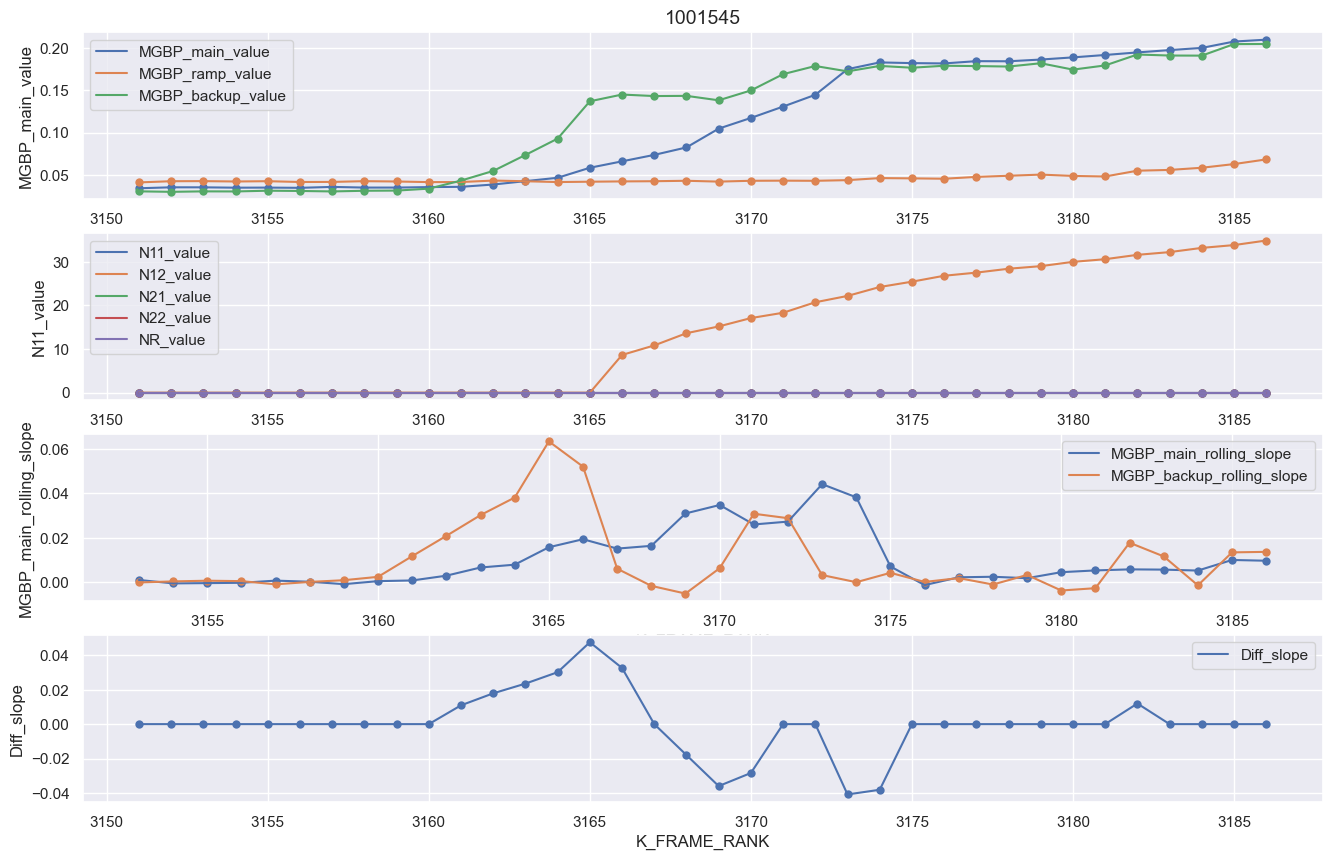

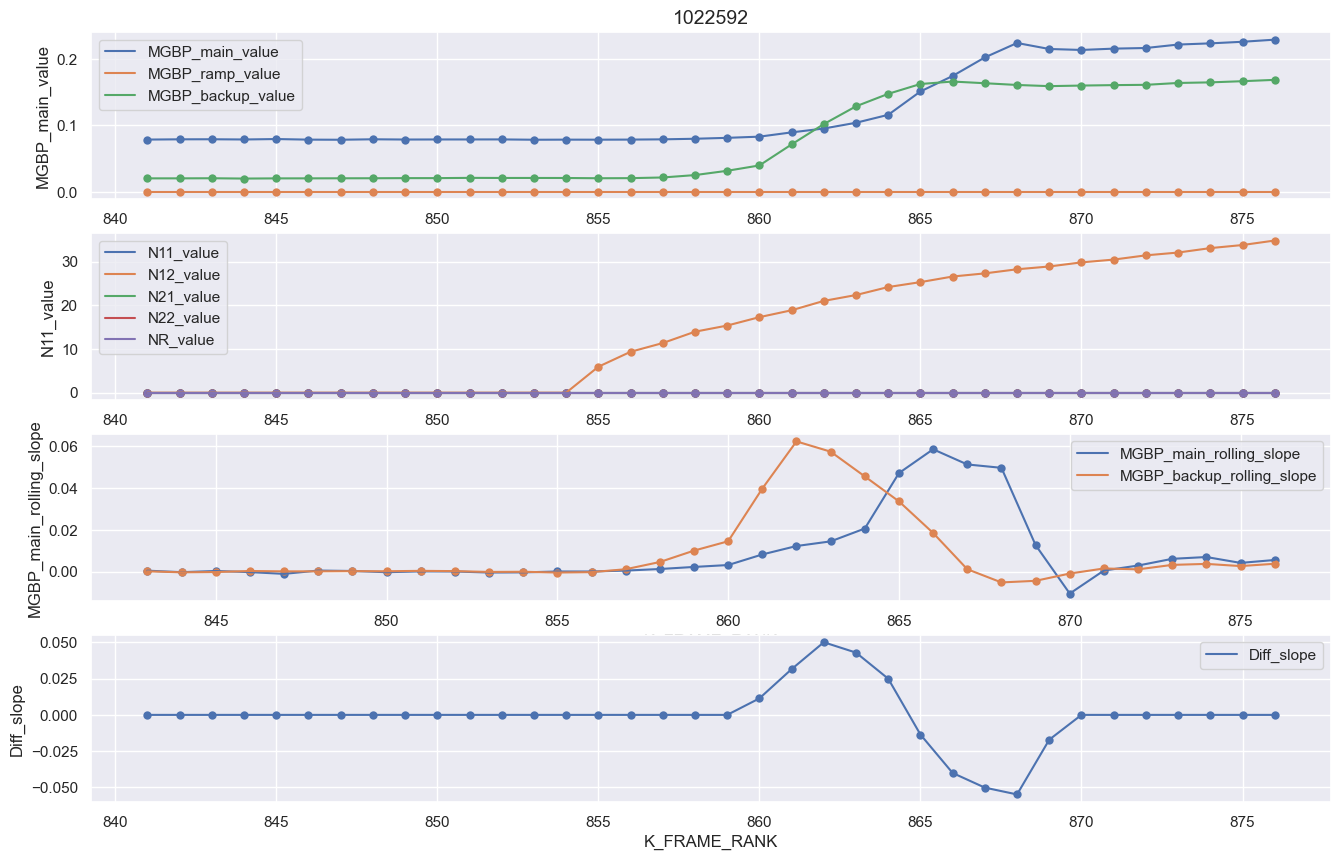

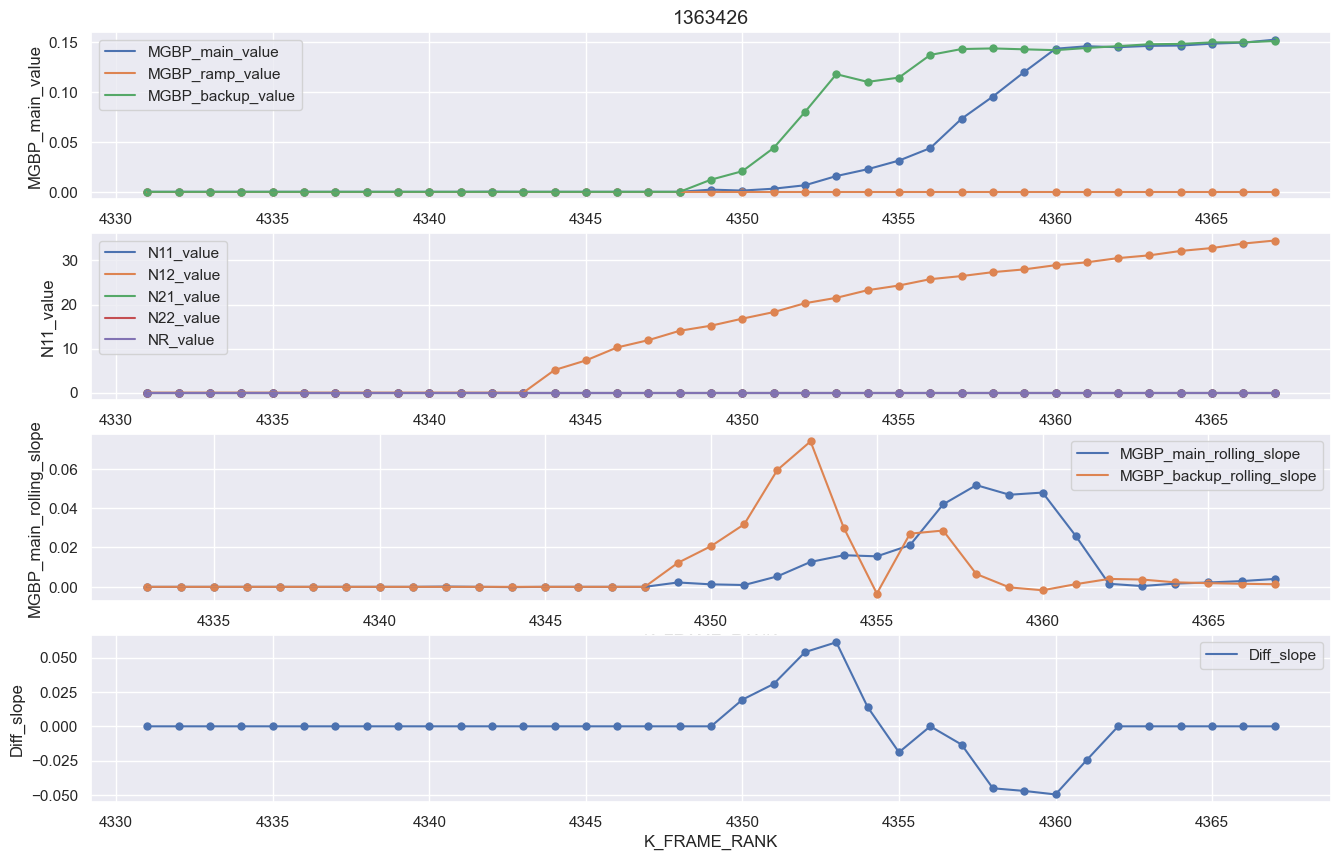

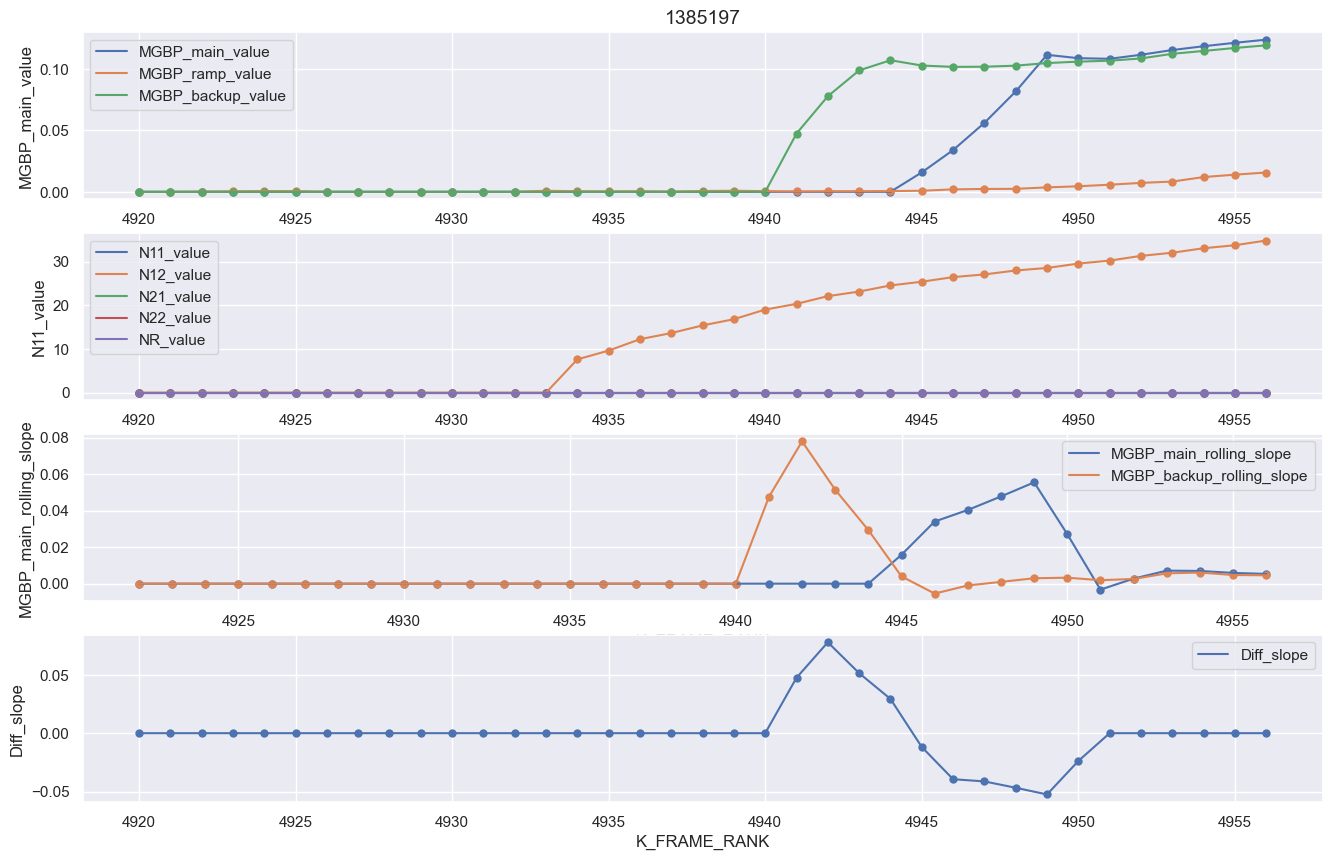

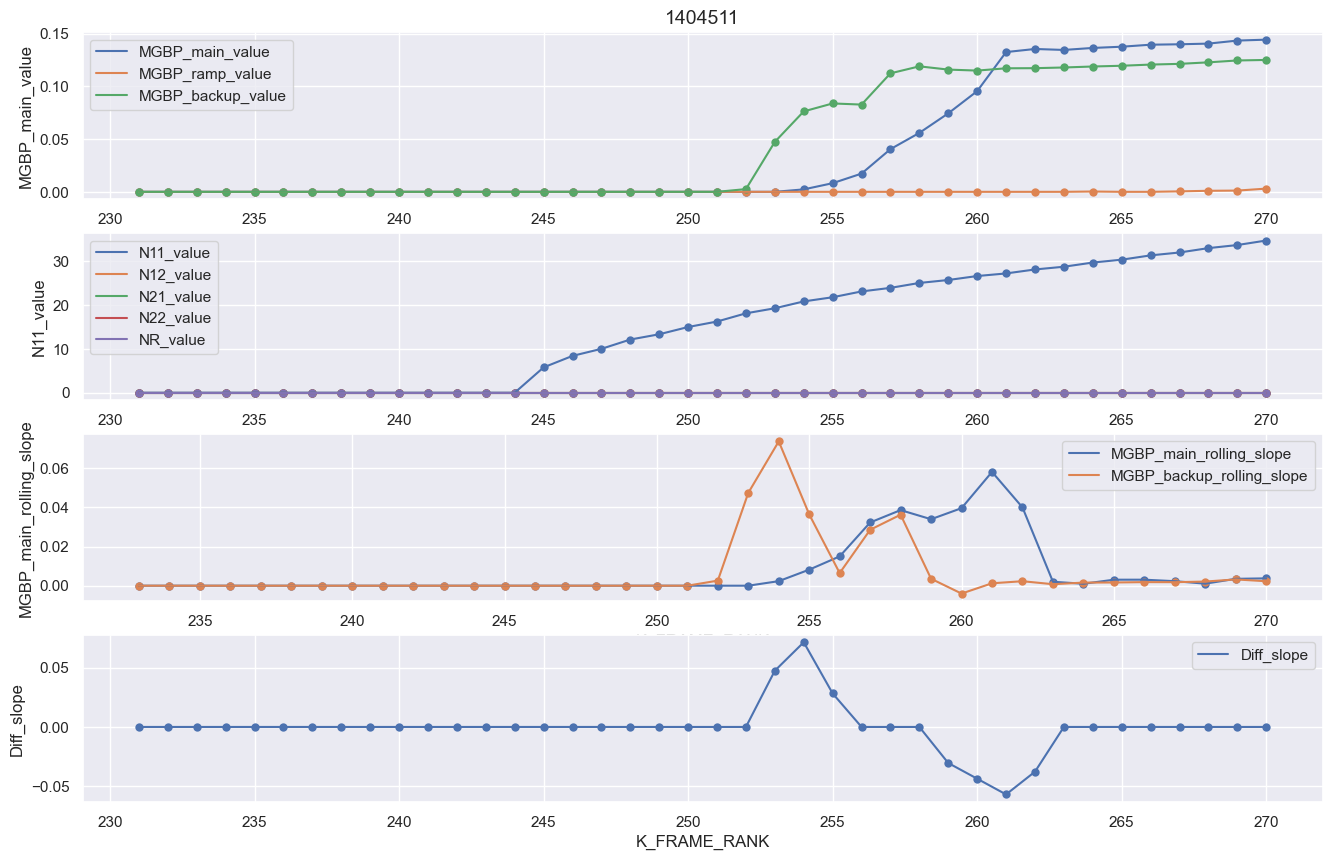

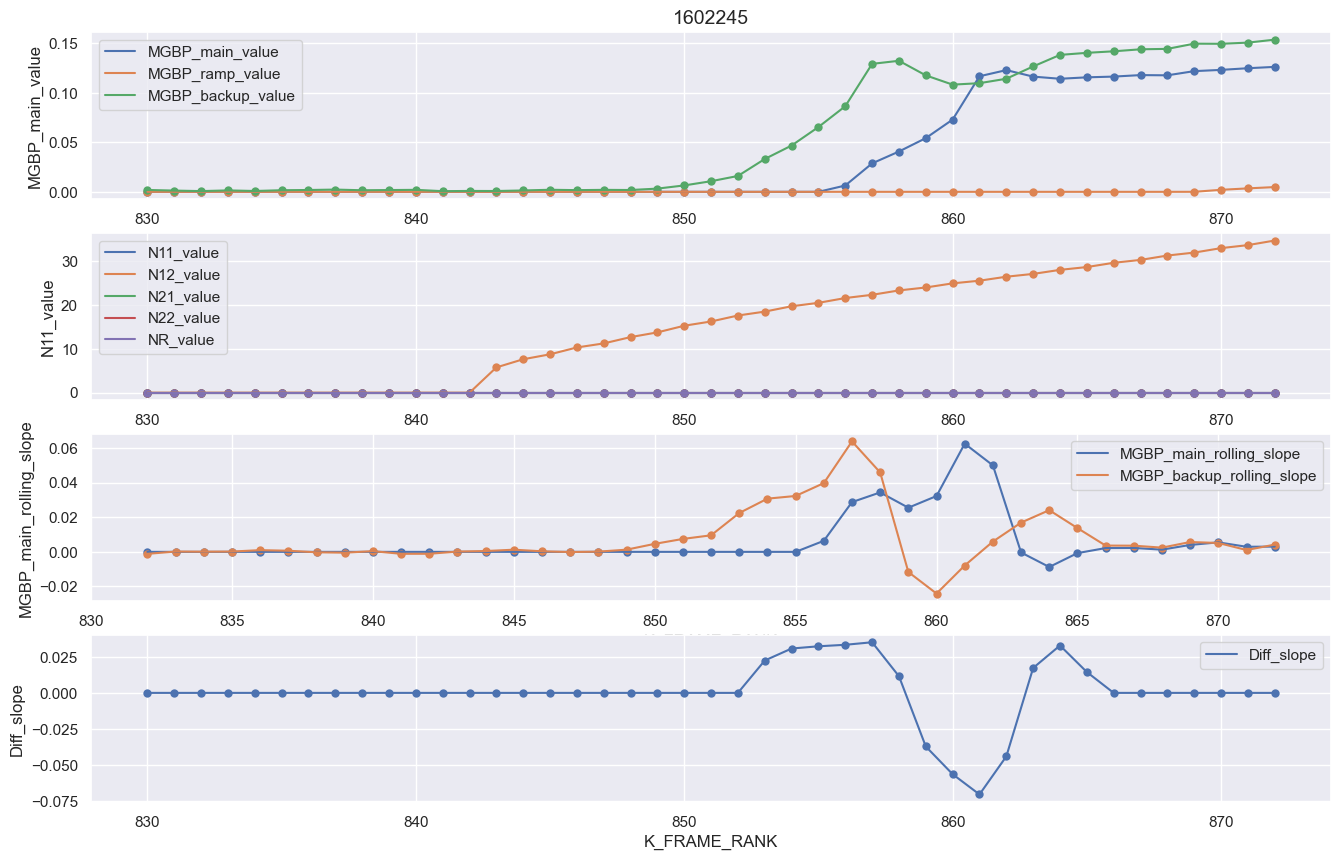

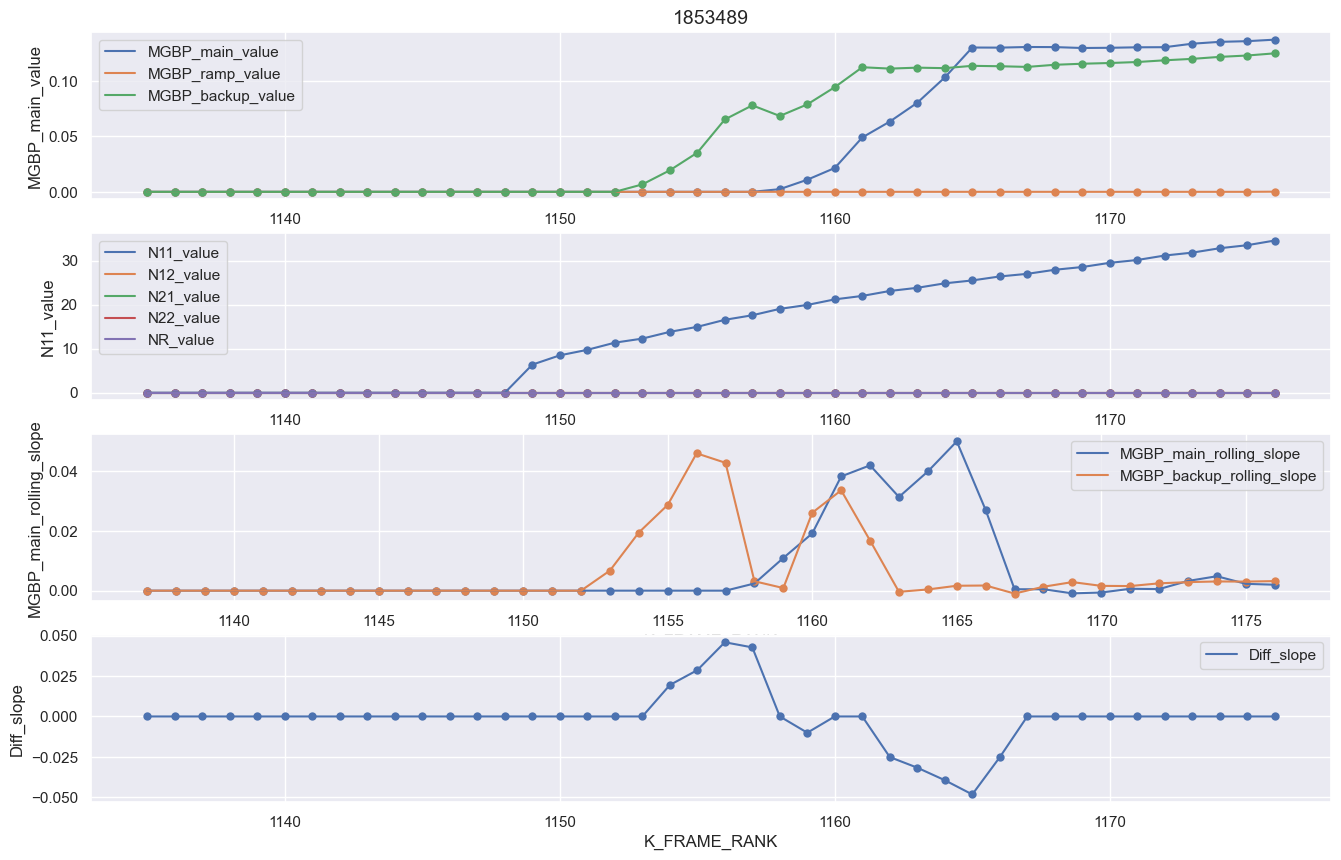

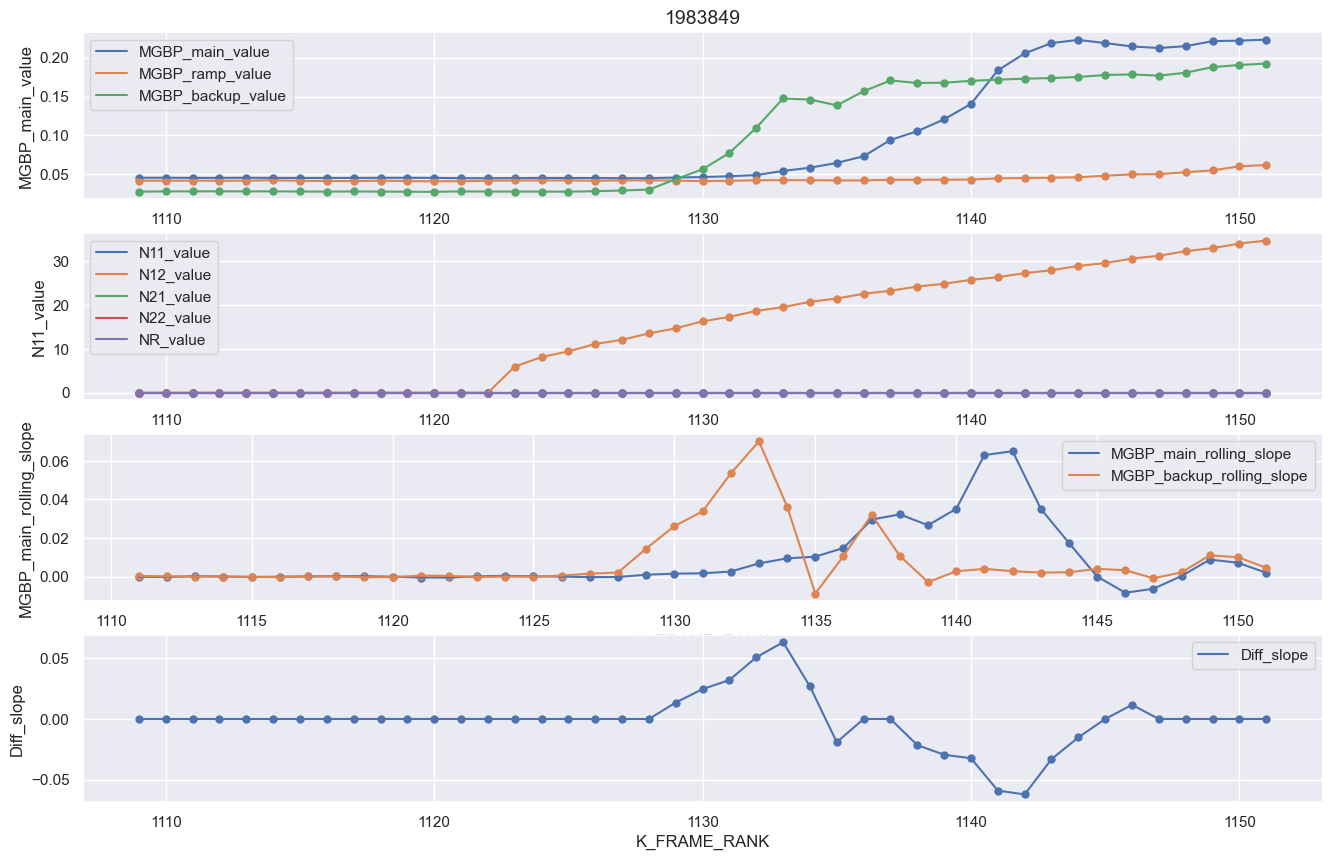

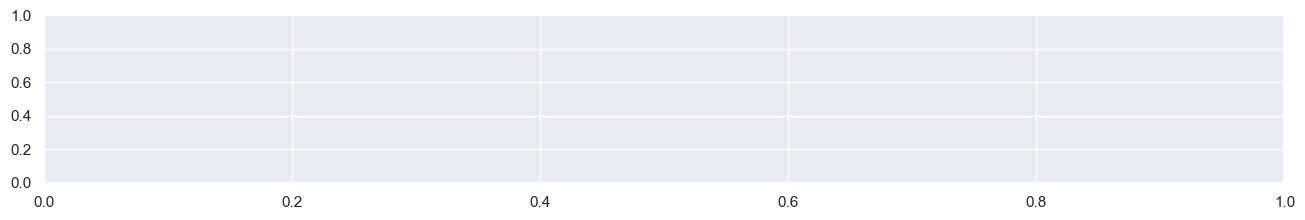

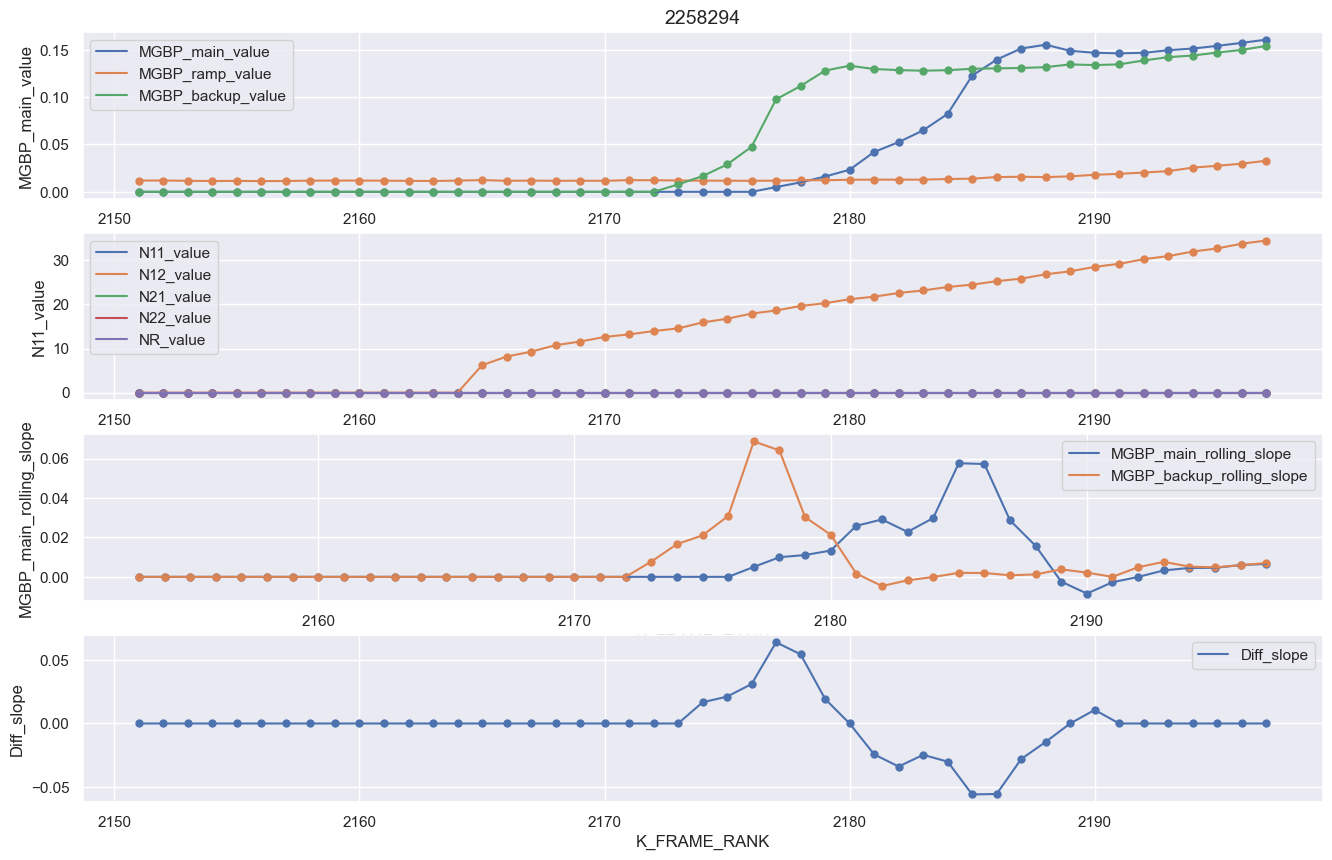

In [290]:
sessions = np.unique(df.F_SESSION)
result = pd.DataFrame()

for s in sessions:
    extract = df[df.F_SESSION == s]
    session = get_start_frames(extract)
    
    try:
        plot(session)
        result = pd.concat([result,session],ignore_index=True)
    except:
        display(session)

In [314]:
for s in sessions:
    extract = df[df.F_SESSION == s]
    session = get_start_frames(extract)
    
    try:
        signal = session.Diff_slope.values
        signal_sign = np.sign(signal)
        check_signs = [(x[0],len(list(x[1]))) for x in itertools.groupby(signal_sign)]
        
        for x in check_signs:
            
        
        
        check_signs
        
        print(check_signs)
    except:
        continue

[(0.0, 10), (1.0, 6), (0.0, 1), (-1.0, 3), (0.0, 2), (-1.0, 2), (0.0, 7), (1.0, 1), (0.0, 4)]
[(0.0, 19), (1.0, 5), (-1.0, 5), (0.0, 7)]
[(0.0, 19), (1.0, 5), (-1.0, 1), (0.0, 1), (-1.0, 5), (0.0, 6)]
[(0.0, 21), (1.0, 4), (-1.0, 6), (0.0, 6)]
[(0.0, 22), (1.0, 3), (0.0, 3), (-1.0, 4), (0.0, 8)]
[(0.0, 23), (1.0, 6), (-1.0, 4), (1.0, 3), (0.0, 7)]
[(0.0, 19), (1.0, 4), (0.0, 1), (-1.0, 1), (0.0, 2), (-1.0, 5), (0.0, 10)]
[(0.0, 20), (1.0, 6), (-1.0, 1), (0.0, 2), (-1.0, 7), (0.0, 1), (1.0, 1), (0.0, 5)]
[(0.0, 23), (1.0, 6), (0.0, 1), (-1.0, 8), (0.0, 1), (1.0, 1), (0.0, 7)]
